In [30]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
from functools import partial
from matplotlib.pyplot import figure
from scipy.optimize import nnls
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,6]

In [5]:
orig_data = pd.read_csv('day.csv')
orig_data.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


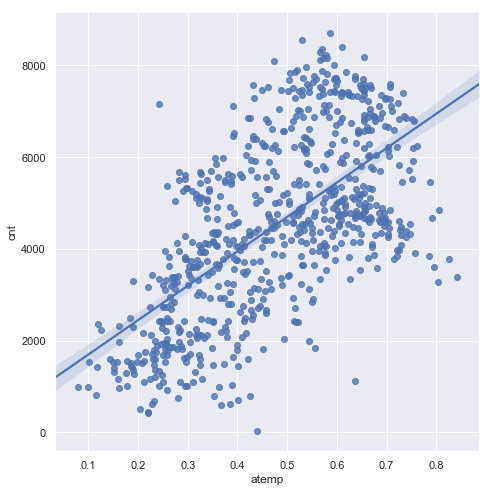

In [6]:
sns.set(color_codes=True)
filtered_df = orig_data
sns.lmplot(x="atemp", y="cnt", height=7, data=filtered_df);

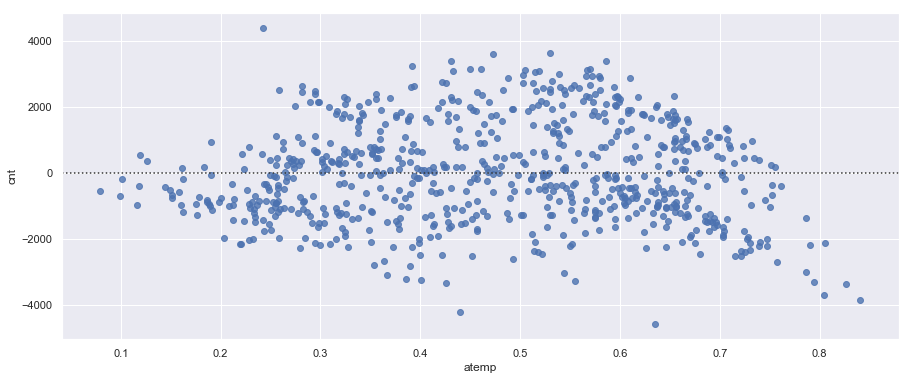

In [482]:
sns.residplot(x="atemp", y="cnt", data=filtered_df)

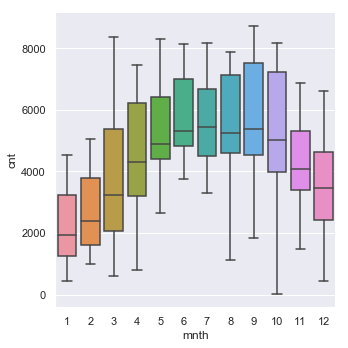

In [483]:
sns.catplot(x="mnth", y="cnt", kind="box", data=filtered_df);

In [484]:
#sns.catplot(x="hr", y="cnt", kind="box", data=filtered_df);

In [485]:
x = filtered_df["windspeed"]
y = filtered_df["atemp"]
np.corrcoef(x, y)[0][1]

-0.18364296669082852

In [7]:
def get_all_X_columns(df):
    return df[df.columns.difference(['cnt', 'registered', 'casual'])]

def get_X_columns(df):
    col_prefixes = ["atemp", "hum", "windspeed", "weathersit", "mnth"]
    filter_col = [col for col in df if any([col.startswith(prefix) for prefix in col_prefixes])]
    return df[filter_col]

def get_Y_column(df):
    return df["cnt"]

In [8]:
def get_XY(data, X_columns_func=get_all_X_columns):
    X = X_columns_func(data).values
    Y = get_Y_column(data).values
    return X, Y

In [9]:
def get_model(X_train, Y_train):
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, Y_train)
    return model

In [10]:
def get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred):    
    training_rmse = math.sqrt(mean_squared_error(Y_train_pred, Y_train))
    test_rmse = math.sqrt(mean_squared_error(Y_test_pred, Y_test))
    training_rsq = r2_score(Y_train_pred, Y_train)
    test_rsq = r2_score(Y_test_pred, Y_test)
    return training_rmse, test_rmse, training_rsq, test_rsq

In [11]:
def plot_histogram(X, Y):
    print(list(zip(X, Y)))
    plt.bar(X, Y)
    for a,b in zip(X, Y):
        plt.text(a, b, "{0:.2f}".format(b))

    plt.show()
    
def plot_feature_weights(data, intercept, coef, X_columns_func=get_all_X_columns):
    features = np.append(X_columns_func(data).columns.values, "intercept")
    weights = np.append(coef, intercept)
    plot_histogram(features, weights)

[('atemp', 6940.300289437367), ('hum', -3125.111517012158), ('windspeed', -3538.565175890242), ('mnth_2', 30.640626145662964), ('mnth_3', 624.9760530738293), ('mnth_4', 931.1715553976746), ('mnth_5', 1125.4601623612637), ('mnth_6', 665.3659519065593), ('mnth_7', 15.13231049549563), ('mnth_8', 629.4866250294758), ('mnth_9', 1558.1784226925251), ('mnth_10', 1759.5182891763325), ('mnth_11', 1262.2576981648604), ('mnth_12', 842.1013378195397), ('weathersit_2', -199.66146369836122), ('weathersit_3', -1821.7073389260968), ('intercept', 3179.548327953248)]


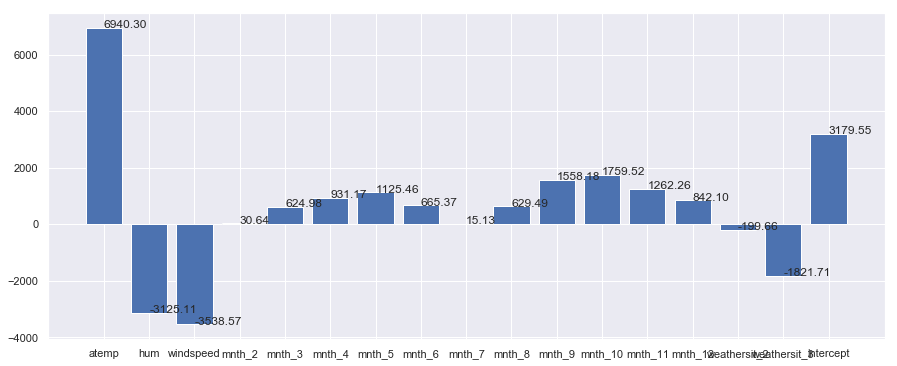

In [60]:
## Fitting attempt 1
encoded_data = orig_data.drop(["instant", "dteday", "yr", "weekday", "workingday", "holiday", "season"], axis=1)
categorical_cols = ["mnth", "weathersit"]
encoded_data = pd.get_dummies(encoded_data, prefix=categorical_cols, columns=categorical_cols, drop_first=True)
X_train, Y_train = get_XY(encoded_data, get_X_columns)
model = get_model(X_train, Y_train)
plot_feature_weights(encoded_data, model.intercept_, model.coef_, get_X_columns)

In [21]:
def f_test(X_train, Y_train):
    f_scores = []
    p_values = []
    num_columns = X_train.shape[1]
    deg_freedom = Y_train.shape[0] - num_columns - 1
    
    model_p1 = get_model(X_train, Y_train)
    Y_pred_p1 = model_p1.predict(X_train)
    rss_p1 = mean_squared_error(Y_pred_p1, Y_train)
    
    for col_id in range(0, num_columns):
        X_train_p0 = np.delete(X_train, col_id, 1)
        model_p0 = get_model(X_train_p0, Y_train)
        Y_pred_p0 = model_p0.predict(X_train_p0)
        rss_p0 = mean_squared_error(Y_pred_p0, Y_train)
        
        f_score = (rss_p0 - rss_p1) * deg_freedom / rss_p1
        p_value = 1 - stats.f.cdf(f_score, 1, deg_freedom)
        f_scores.append(f_score)
        p_values.append(p_value)
        
    return f_scores, p_values

[('atemp', 95.67730703992981), ('hum', 41.49186756675245), ('windspeed', 26.86805116014373), ('mnth_2', 0.015868903533206247), ('mnth_3', 5.988434402720229), ('mnth_4', 10.853795021498362), ('mnth_5', 12.099951396197751), ('mnth_6', 3.2995521135797587), ('mnth_7', 0.0014305696615551904), ('mnth_8', 2.9134250116206752), ('mnth_9', 22.009902744074072), ('mnth_10', 38.271809056456675), ('mnth_11', 25.02932372898501), ('mnth_12', 12.054869988492623), ('weathersit_2', 2.385439557235246), ('weathersit_3', 30.313205847327662)]


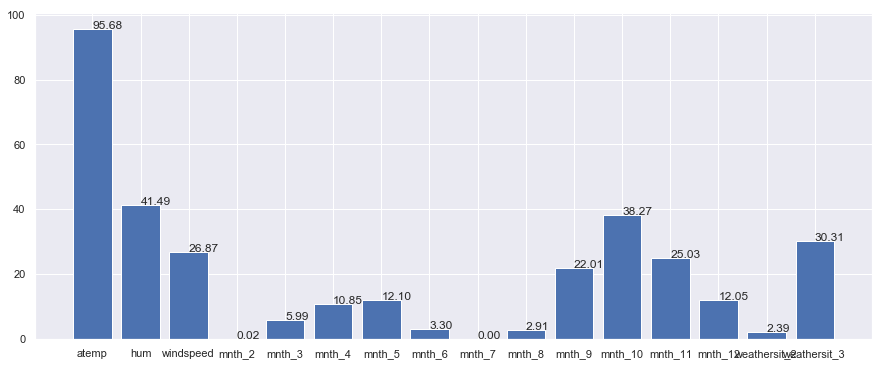

[('atemp', 1.1102230246251565e-16), ('hum', 2.1748114420461206e-10), ('windspeed', 2.8386896977483644e-07), ('mnth_2', 0.8997896809090806), ('mnth_3', 0.014639941897626962), ('mnth_4', 0.0010346026510484885), ('mnth_5', 0.0005348161328375678), ('mnth_6', 0.06971796934052499), ('mnth_7', 0.9698394803587623), ('mnth_8', 0.08827992936285767), ('mnth_9', 3.251117999036879e-06), ('mnth_10', 1.0363068181362678e-09), ('mnth_11', 7.116065199319621e-07), ('mnth_12', 0.0005476836289585174), ('weathersit_2', 0.12291352229605823), ('weathersit_3', 5.130956393095687e-08)]


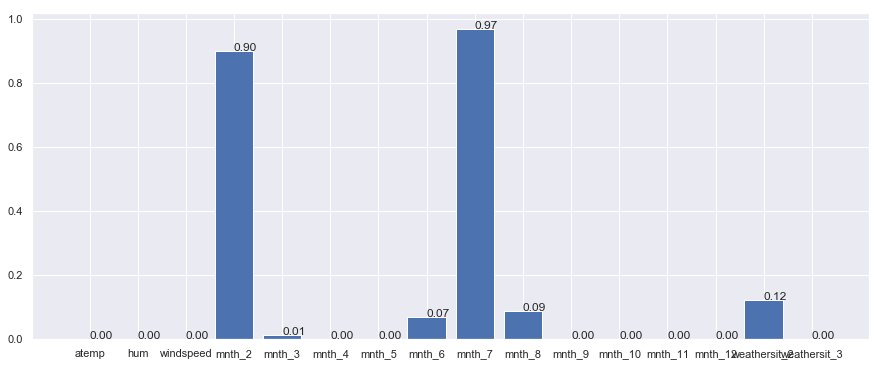

In [22]:
f, p = f_test(X_train, Y_train)
plot_histogram(get_X_columns(encoded_data).columns, f)
plot_histogram(get_X_columns(encoded_data).columns, p)

In [61]:
results = encoded_data
results['predicted']=model.predict(get_X_columns(results))
results['residual']=results['predicted'] - get_Y_column(results)

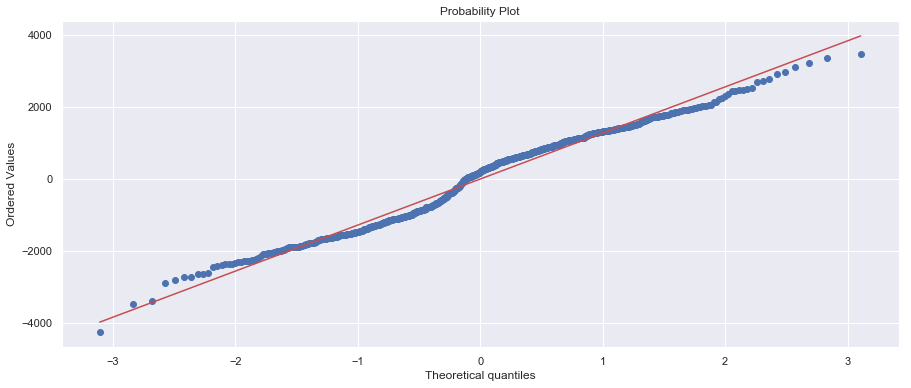

In [62]:
# Q-Q Plot
stats.probplot(results['residual'], dist="norm", plot=pylab)
pylab.show()

The above Q-Q plot implies that there are outliers in the data, both in the negative side (y_actual is much less than y_pred) and on the positive side (y_actual is much higher than y_pred).

In [29]:
results[(results.residual < -2000) | (results.residual > 3000)].head(10)

,temp,atemp,hum,windspeed,casual,registered,cnt,mnth_2,mnth_3,mnth_4,...,mnth_10,mnth_11,mnth_12,season_2,season_3,season_4,weathersit_2,weathersit_3,predicted,residual
68,0.389091,0.385668,0.000000,0.261877,46,577,623,0,1,0,...,0,0,0,0,0,0,0,1,3732.799942,3109.799942
202,0.848333,0.840896,0.580417,0.133100,562,2825,3387,0,0,0,...,0,0,0,0,1,0,0,0,6745.900514,3358.900514
203,0.849167,0.804287,0.500000,0.131221,987,2298,3285,0,0,0,...,0,0,0,0,1,0,0,0,6749.784118,3464.784118
327,0.373333,0.372471,0.549167,0.167304,560,935,1495,0,0,0,...,0,1,0,0,0,1,0,0,4718.642391,3223.642391
406,0.224167,0.210867,0.731250,0.289796,192,1977,2169,1,0,0,...,0,0,0,0,0,0,0,1,-458.737914,-2627.737914
441,0.514167,0.505046,0.755833,0.110704,3155,4681,7836,0,1,0,...,0,0,0,0,0,0,1,0,4356.238085,-3479.761915
442,0.472500,0.464000,0.810000,0.126883,2207,3685,5892,0,1,0,...,0,0,0,0,0,0,1,0,3844.838158,-2047.161842
446,0.554167,0.531567,0.831250,0.117562,1334,5537,6871,0,1,0,...,0,0,0,1,0,0,0,0,4480.009237,-2390.990763
447,0.601667,0.570067,0.694167,0.116300,2469,5893,8362,0,1,0,...,0,0,0,1,0,0,1,0,4980.414666,-3381.585334
455,0.424167,0.421708,0.738333,0.250617,2301,3934,6235,0,1,0,...,0,0,0,1,0,0,1,0,3337.445521,-2897.554479


In [97]:
def cross_validate_error(data, model_builder):
    sum_train_error = 0
    sum_test_error = 0
    sum_train_rsq = 0
    sum_test_rsq = 0

    splits = 5
    kf = KFold(n_splits=splits)
    for train_indices, test_indices in kf.split(data):
        data_train = data.iloc[train_indices]
        data_test = data.iloc[test_indices]
        #print ("Training, test data shape:", data_train.shape, data_test.shape)
    
        X_data_train, Y_data_train = get_XY(data_train, get_X_columns)
        model = model_builder(X_data_train, Y_data_train)
        #plot_feature_weights(data, model.intercept_, model.coef_, get_X_columns)
    
        X_train, Y_train = get_XY(data_train, get_X_columns)
        X_test, Y_test = get_XY(data_test, get_X_columns)
        Y_train_pred, Y_test_pred = model.predict(X_train), model.predict(X_test)
        training_rmse, test_rmse, training_rsq, test_rsq = \
        get_errors(Y_train, Y_train_pred, Y_test, Y_test_pred)
    
        sum_train_error += training_rmse
        sum_test_error += test_rmse
        sum_train_rsq += training_rsq
        sum_test_rsq += test_rsq   

    #print(sum_train_error/splits, sum_test_error/splits, sum_train_rsq/splits, sum_test_rsq/splits)
    return (sum_test_error/splits)

In [98]:
cross_validate_error(encoded_data, get_model)/np.mean(Y_train)

0.46502722672186536

In [95]:
# try non negative linear regression
class NonLinearModel:    
    def fit(self, X, Y):
        X_1 = np.concatenate((X, np.ones(X.shape[0])[:, np.newaxis]), axis=1)
        self.W = nnls(X_1, Y)[0]
    
    def predict(self, X_seq):
        Y_seq = []
        for X in X_seq:
            Y_seq.append(self._predict_one_(X))        
        return np.array(Y_seq)
            
    def _predict_one_(self, X):
        return np.dot(np.append(np.array(X, dtype=float64), 1), self.W)
    
def get_nnls_model(X, Y):
    model = NonLinearModel()
    model.fit(X, Y)
    return model

In [101]:
cross_validate_error(encoded_data, get_nnls_model)/np.mean(Y_train)

0.5040716835658746

[('atemp', 6551.384818271785), ('hum', 0.0), ('windspeed', 0.0), ('mnth_2', 86.29989709962696), ('mnth_3', 584.5889338200392), ('mnth_4', 885.0436295176434), ('mnth_5', 1038.5612529747802), ('mnth_6', 985.6298666693176), ('mnth_7', 345.5441266257053), ('mnth_8', 791.0136968647103), ('mnth_9', 1365.9619453775526), ('mnth_10', 1501.8041844396093), ('mnth_11', 1235.1312942236802), ('mnth_12', 661.6651797999741), ('weathersit_2', 0.0), ('weathersit_3', 0.0), ('intercept', 605.3435015003548)]


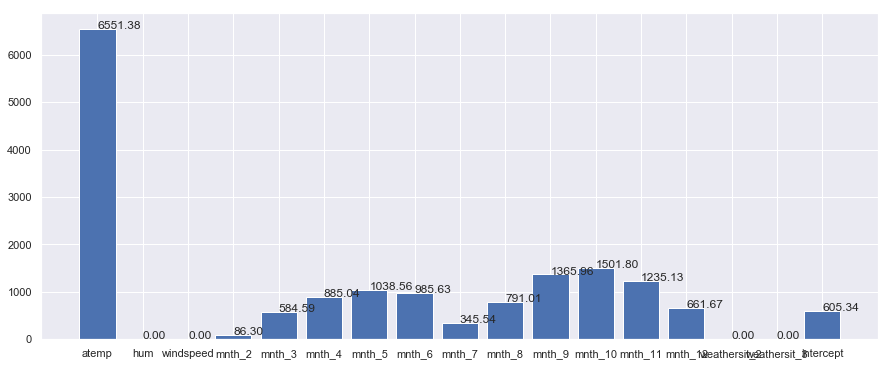

temp               0.224167
atemp              0.210867
hum                0.731250
windspeed          0.289796
casual           192.000000
registered      1977.000000
cnt             2169.000000
mnth_2             1.000000
mnth_3             0.000000
mnth_4             0.000000
mnth_5             0.000000
mnth_6             0.000000
mnth_7             0.000000
mnth_8             0.000000
mnth_9             0.000000
mnth_10            0.000000
mnth_11            0.000000
mnth_12            0.000000
weathersit_2       0.000000
weathersit_3       1.000000
predicted       2073.114261
residual         -95.885739
Name: 406, dtype: float64

In [104]:
X_train, Y_train = get_XY(encoded_data, get_X_columns)
nnls_model = get_nnls_model(X_train, Y_train)
plot_feature_weights(encoded_data, nnls_model.W[-1], nnls_model.W[:-1] , get_X_columns)
results = encoded_data
results['predicted']=nnls_model.predict(get_X_columns(results).values)
results['residual']=results['predicted'] - get_Y_column(results)
results.iloc[406]